In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision.datasets import EMNIST
import torch
import random

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.datasets.emnist import Emnist
 

def plot_client_training(settings_files, alg, weight_scheme, student_model=None, loss=None):    
    student_model = student_model + "_" if student_model is not None else ""
    loss = loss + "_" if loss is not None else ""

    dataset = settings_files[0].split('_')[0]
    
    fig, ax = plt.subplots(2, len(seeds), figsize=(15,6))
    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/{alg}/{set}"
        client_accs = []
        with open(f"{results_path}/client_accuracy.npy", "rb") as f:
            try:
                while True:
                    client_accs.extend([np.load(f)])
            except:
                pass

        client_losses = []
        with open(f"{results_path}/client_loss.npy", "rb") as f:
            try:
                while True:
                    client_losses.extend([np.load(f)])
            except:
                pass

        for accs in client_accs:
            ax[0][i].plot(accs)

        for losses in client_losses:
            ax[1][i].plot(losses)
    plt.show()  

def plot_student_results(settings_files, n_pub, model, loss, weight_scheme):
    fig, ax = plt.subplots(len(settings_files), len(n_pub), figsize=(15,15))
    test_acc_lists = [[] for _ in range(len(n_pub))]
    ensemble_test_acc = [[] for _ in range(len(settings_files))]
    dataset = settings_files[0].split('_')[0]

    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/feded/{set}/w{weight_scheme}_student_emnist_{model}_{loss}"

        for j, n in enumerate(n_pub):
            with open(f"{results_path}_train_results_{n}.npy", "rb") as f:
                train_accs = np.load(f)
                train_losses = np.load(f)
                val_accs = np.load(f)
                val_losses = np.load(f)

            with open(f"{results_path}_test_results_{n}.npy", "rb") as f:
                test_results = np.load(f)

            ax[i][j].plot(train_accs)
            ax[i][j].plot(val_accs)
            ax[i][j].set_ylim([10,100])
            test_acc_lists[j].append(test_results[0])
            
        with open(f"../results/{dataset}/feded/{set}/w{weight_scheme}_ensemble_test_acc.npy", "rb") as f:
                ensemble_test_acc[i] = np.load(f)[0]
        
    plt.show()
    print("Test accuracy \n\n")
    print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} | {:<10}".format('Run\Public size', n_pub[0], n_pub[1], n_pub[2], n_pub[3], n_pub[4], 'Ensemble'))
    for run in range(len(settings_files)):
        print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} | {:<10.2f} ".format(run, 
                                                  test_acc_lists[0][run],
                                                  test_acc_lists[1][run],
                                                  test_acc_lists[2][run],
                                                  test_acc_lists[3][run],
                                                               test_acc_lists[4][run],
                                                    ensemble_test_acc[run]))
    print("")
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Mean',
                                                     np.mean(test_acc_lists[0]),
                                                     np.mean(test_acc_lists[1]),
                                                     np.mean(test_acc_lists[2]),
                                                     np.mean(test_acc_lists[3]),
                                                                np.mean(test_acc_lists[4]),
                                                                np.mean(ensemble_test_acc)))
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Std',
                                                    np.std(test_acc_lists[0]),
                                                    np.std(test_acc_lists[1]),
                                                    np.std(test_acc_lists[2]),
                                                    np.std(test_acc_lists[3]),
                                                            np.std(test_acc_lists[4]),
                                                            np.std(ensemble_test_acc)))

def print_test_results(settings_files, alg):    
    #fig, ax = plt.subplots(1, 2, figsize=(15,6))
    dataset = settings_files[0].split('_')[0]
    test_acc_list = []
    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/{alg}/{set}"

        with open(f"{results_path}/fedavg_test_results.npy", "rb") as f:
            test_accs = np.load(f)
            test_losses = np.load(f)

        #ax[0].plot(test_accs)
        #ax[1].plot(test_losses)
        test_acc_list.append(test_accs[-1])
    # ax[0].set_ylabel("Accuracy")
    # ax[0].set_xlabel("Communication round")
    # ax[1].set_ylabel("Loss")
    # ax[1].set_xlabel("Communication round")
    #plt.show()
    print("{:<8} {:<10}".format('Run', 'Test accuracy'))
    for run in range(len(settings_files)):
        print("{:<8} {:<10}".format(run, test_acc_list[run]))
    print("")
    print("{:<8} {:<10.2f}".format('Mean', np.mean(test_acc_list)))
    print("{:<8} {:<10.2f}".format('Std', np.std(test_acc_list)))
                                                

In [2]:
distribution = "niid0.01"
seeds = [1,2,3,4,5,6,7,8,9,10]
n_clients = 10
model = "emnist_cnn1"
settings_files = [f"{model}_c{n_clients}_{distribution}_s{i}" for i in seeds]

In [3]:
from src.models.models import Emnist_Cnn1, Emnist_Cnn2, Emnist_Cnn3

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in [Emnist_Cnn1(), Emnist_Cnn2(), Emnist_Cnn3()]:
    print(count_parameters(model))

2626
20826
23834


# FedAVG
```
class Emnist_Cnn1(nn.Module):
    def __init__(self):
        super(Emnist_Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 5, 1, 2)
        self.pool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(2 * 7 * 7, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
```

Centralized model ~80 % accuracy

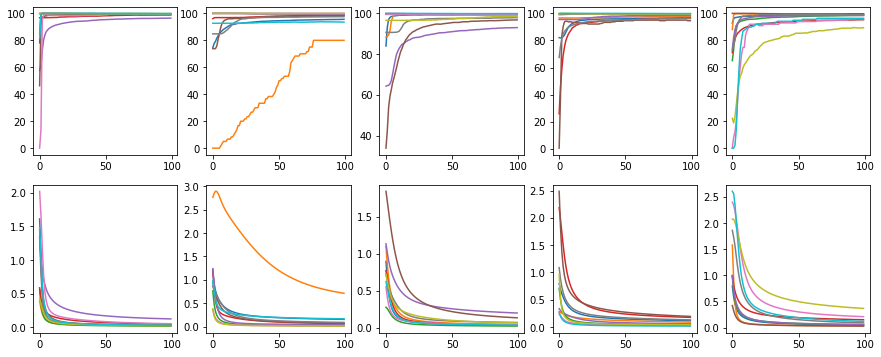

In [3]:
plot_client_training(settings_files, "fedavg", 0)

In [25]:
print_test_results(settings_files, "fedavg")

Run      Test accuracy
0        68.48557692307692
1        65.90384615384616
2        63.71634615384615
3        65.65865384615384
4        65.71634615384616
5        67.1298076923077
6        66.86538461538461
7        68.01442307692308
8        61.61538461538461
9        66.3798076923077

Mean     65.95     
Std      1.92      


In [5]:
print_test_results(settings_files, "fedprox")

Run      Test accuracy
0        95.01     
1        93.16     
2        93.47     
3        93.59     
4        93.87     

Mean     93.82     
Std      0.64      


# FedED


$$
  \mathbf{\hat{z}} = \sum_{k\in\mathcal{K}_t} \omega_k \mathbf{z}^k, \quad \omega^k = \frac{N^k}{\sum_{k\in\mathcal{K}_t} N^k}
$$

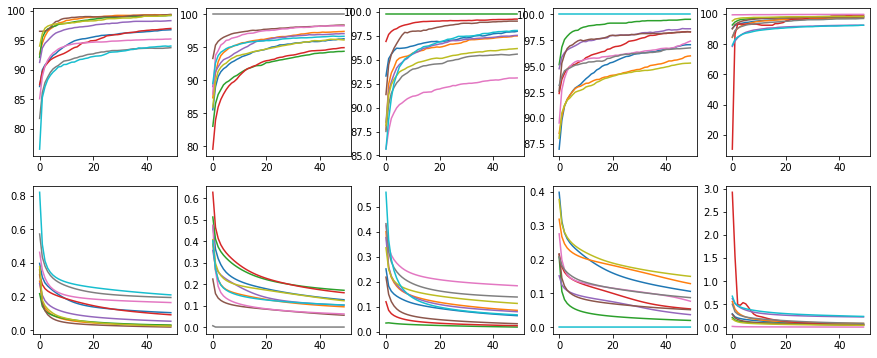

In [4]:
plot_client_training(settings_files, "feded", 0, "cnn1", "mse")

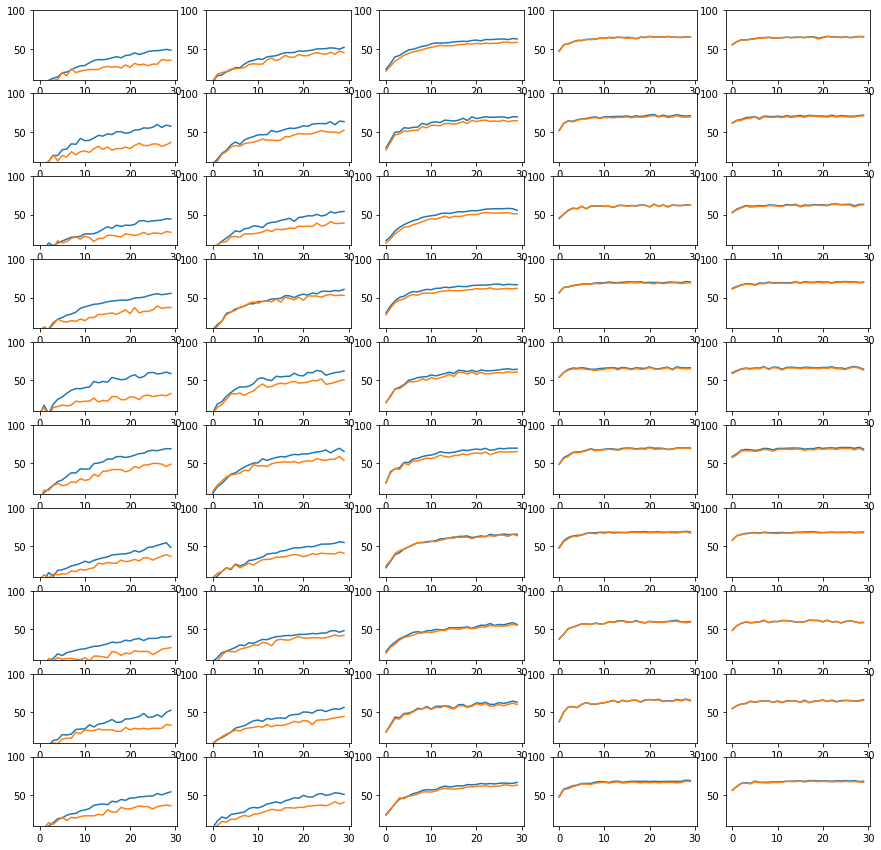

Test accuracy 


Run\Public size 500        1000       5000       30000      60000      | Ensemble  
0               25.18      28.78      37.79      40.78      40.62      | 37.76      
1               23.39      27.79      33.10      34.42      36.55      | 36.48      
2               20.79      29.47      34.72      40.20      40.71      | 36.43      
3               24.42      29.05      36.34      37.96      38.42      | 37.38      
4               24.41      30.41      34.83      37.67      37.90      | 30.90      
5               26.44      31.57      34.27      36.99      37.10      | 33.30      
6               22.28      27.97      35.86      37.76      39.01      | 35.98      
7               17.95      24.95      34.11      35.55      34.77      | 33.14      
8               16.96      22.70      24.58      27.89      28.41      | 25.40      
9               26.45      28.76      42.94      44.80      45.63      | 42.51      

Mean            22.83      28.15      34.85     

In [26]:
plot_student_results(settings_files, [500, 1000, 5000, 30000, 60000], "cnn2", "mse", 0)

# FedED weight scheme 1

$$
  \mathbf{\hat{z}}_c = \sum_{k\in\mathcal{K}_t} \omega^c_k \mathbf{z}^k_c, \quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$

In [36]:
#plot_client_training("mnist", "feded", 1, "cnn2")

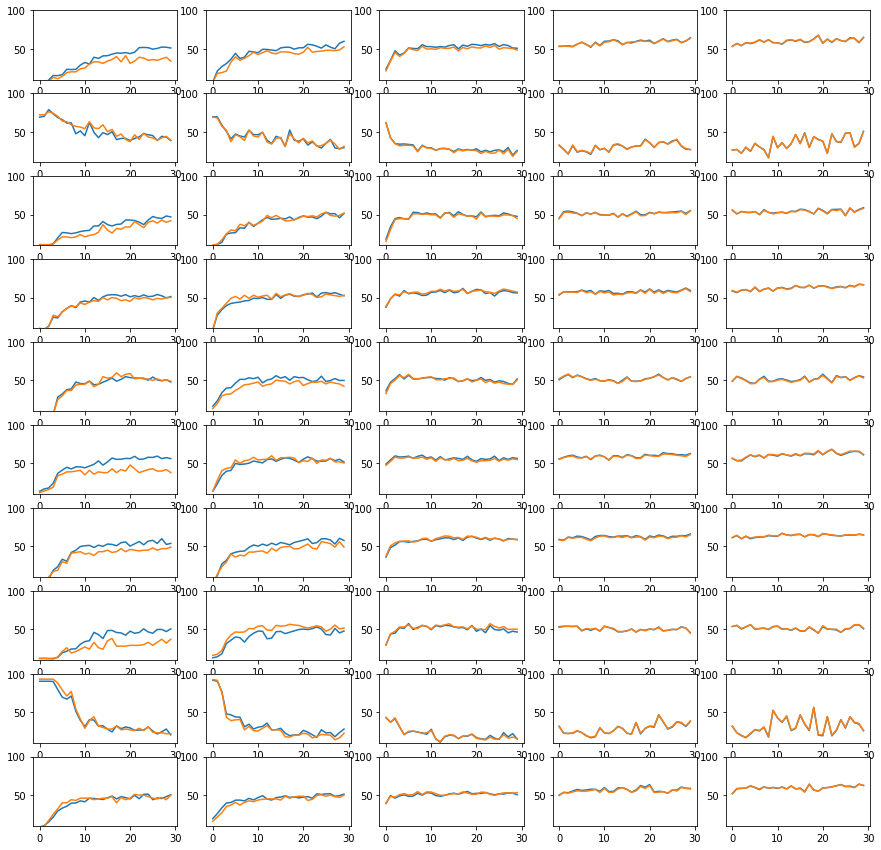

Test accuracy 


Run\Public size 500        1000       5000       30000      60000      | Ensemble  
0               28.98      33.85      35.64      36.24      38.40      | 42.91      
1               18.88      25.85      27.05      29.32      22.08      | 13.10      
2               28.15      32.52      32.27      35.42      35.27      | 42.04      
3               34.50      35.79      38.23      41.84      43.91      | 48.51      
4               30.46      32.88      33.64      35.06      35.50      | 41.41      
5               34.59      36.65      39.31      38.80      42.24      | 45.30      
6               40.66      41.11      40.88      45.47      44.96      | 52.95      
7               31.69      30.09      28.93      29.39      33.88      | 44.70      
8               22.04      22.96      25.02      24.73      27.69      | 7.16       
9               31.42      33.98      35.52      42.09      38.32      | 45.29      

Mean            30.14      32.57      33.65     

In [27]:
plot_student_results(settings_files, [500, 1000, 5000, 30000, 60000], "cnn3", "mse", 1)

# FedED weight scheme 2

1. Träna autoencoder $H_k$ på privat data $\mathcal{D}_k$.
2. För varje publikt dataexempel $x_j$, notera loss
$$ l_k(x_j) = MSE(H_k(x_j), x_j). $$
3. Ange vikt 
$$\omega^j_k = \frac{1}{l_k(x_j)^6}.$$
3. Bilda viktat medelvärde för logits med aktiva klienter $\mathcal{K}_t$
$$
  \mathbf{\hat{z}}_j = \sum_{k\in\mathcal{K}_t} \omega^j_k \mathbf{z}^j_k. %\quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$
4. Normalisera.

Student loss: 
$$\mathbf{z}_j = F_S(x_j) \qquad MSE(\mathbf{z}_j, \mathbf{\hat{z}}_j)$$
<!-- $$
  \mathbf{\bar{z}}_c = \sum_{k\in\mathcal{K}_t} N_c^k \mathbf{z}^k_c \\
  \mathbf{\hat{z}}_c = \frac{\mathbf{\bar{z}}_c}{\sum_c \mathbf{\bar{z}}_c}
$$ -->

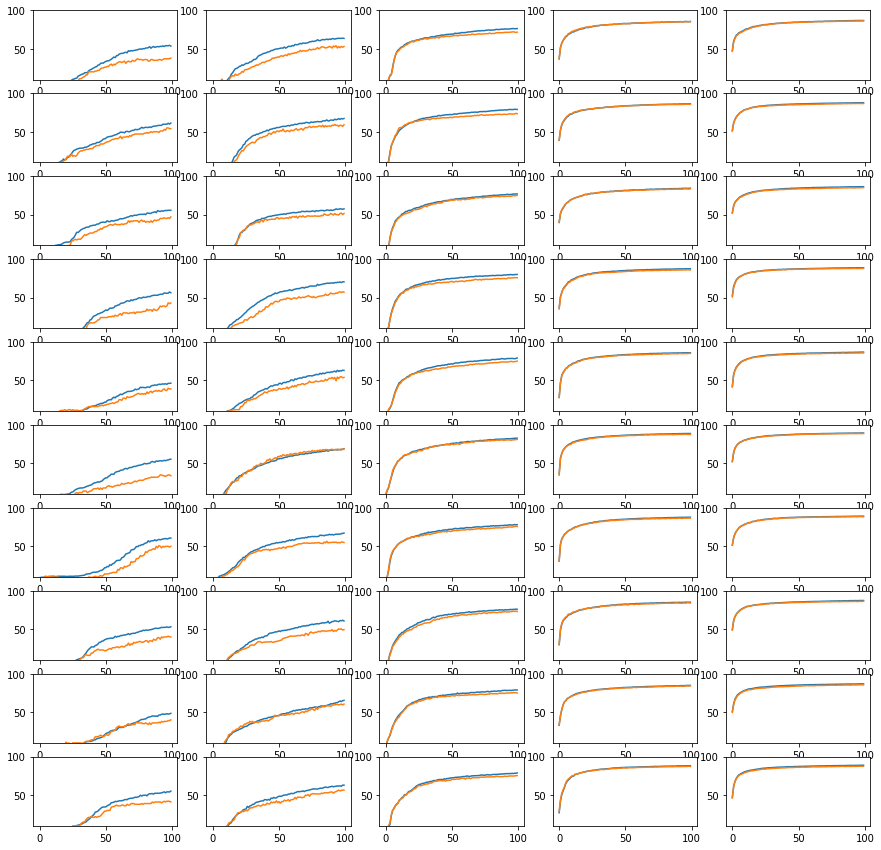

Test accuracy 


Run\Public size 500        1000       5000       30000      60000      | Ensemble  
0               30.80      46.97      66.91      79.98      81.51      | 80.33      
1               45.59      56.57      71.60      82.89      84.80      | 82.16      
2               38.69      48.93      71.90      82.14      84.64      | 81.69      
3               33.88      53.02      70.17      81.67      82.77      | 80.81      
4               32.92      46.84      70.29      81.36      82.18      | 80.43      
5               34.84      54.50      72.06      81.62      83.00      | 81.53      
6               41.22      51.13      68.50      81.31      82.90      | 81.27      
7               27.66      44.30      65.72      78.50      81.07      | 79.27      
8               34.94      51.80      73.11      82.88      84.74      | 82.23      
9               35.83      49.42      72.00      83.72      84.35      | 82.30      

Mean            35.64      50.35      70.23     

In [3]:
plot_student_results(settings_files, [500, 1000, 5000, 30000, 60000], "cnn3", "mse", 2)


Student loss: 
$$CE(\mathbf{t}_j, \mathbf{\hat{t}}_j)$$

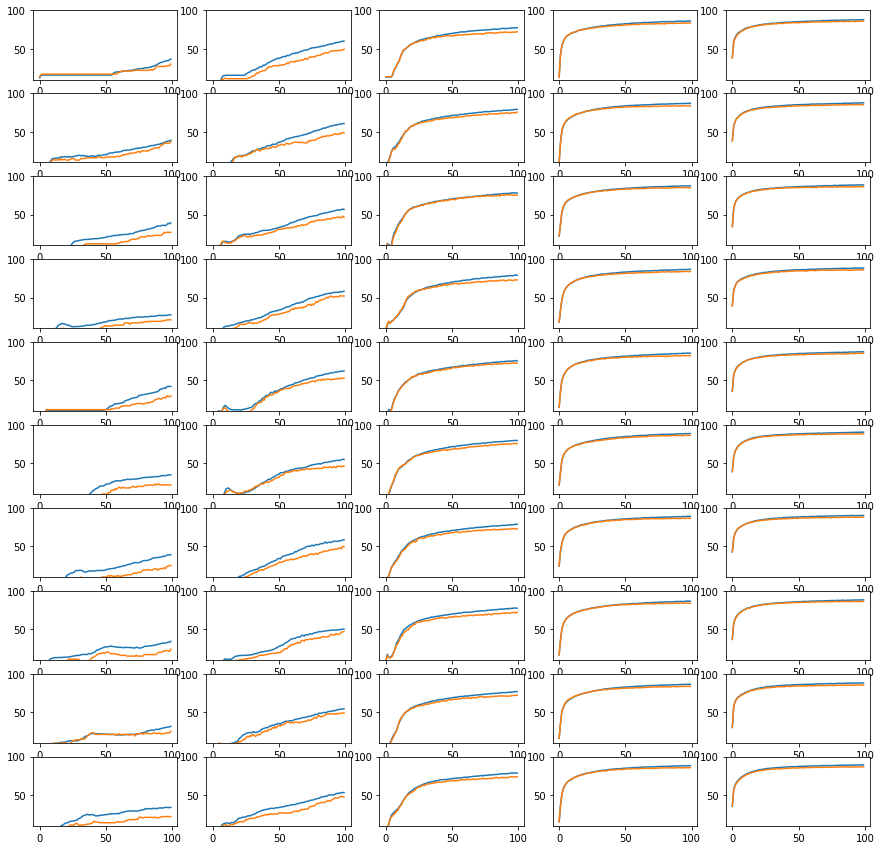

Test accuracy 


Run\Public size 500        1000       5000       30000      60000      | Ensemble  
0               15.15      38.37      63.97      74.58      74.94      | 74.69      
1               25.59      46.44      69.33      78.46      80.13      | 78.80      
2               21.81      42.80      66.41      78.22      79.51      | 77.75      
3               14.32      43.62      64.75      75.47      76.49      | 75.93      
4               20.94      42.96      60.88      73.41      74.93      | 73.39      
5               19.34      41.43      69.92      80.09      82.22      | 81.53      
6               24.68      43.72      68.77      81.43      82.97      | 81.27      
7               14.94      37.67      67.48      77.93      82.25      | 79.27      
8               19.31      46.33      70.70      82.09      84.29      | 82.23      
9               19.24      41.53      70.78      82.15      84.03      | 82.30      

Mean            19.53      42.49      67.30     

In [22]:
plot_student_results(settings_files, [500, 1000, 5000, 30000, 60000], "cnn3", "ce", 2)